PHY312: Multimode Optical Fiber Transmission with a Deep Learning Network
Pratha S Dongre (MS19003), Madhumati Seetharaman (MS19077)

In [1]:
%%time 

import os
import gc

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.linewidth'] = 0

import numpy as np
import pickle
import h5py

from keras.layers import Input, Reshape, Dense,AveragePooling2D, UpSampling2D, Conv2D, Flatten, PReLU, Lambda, Conv1D
from keras.models import Model
from keras.initializers import RandomUniform
from tensorflow.keras.layers import Layer
from keras.constraints import *
from tensorflow.keras.optimizers import SGD
from keras.callbacks import *
#from keras_contrib.losses.dssim import DSSIMObjective
#commenting out as loading package thows errors
import cv2

from ComplexNets import *

import tensorflow as tf
import subprocess
import imageio
from IPython.display import HTML

def axes_off():
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
    
new_folders = ['figures', 'gifs', 'logs', 'models', 'tables', 'triptychs', 'weights']
for new_folder in new_folders:
    if not os.path.isdir(new_folder): 
        os.makedirs(new_folder)

Wall time: 8.67 s


## Figure 1 - Single pixel inputs

Wall time: 735 ms


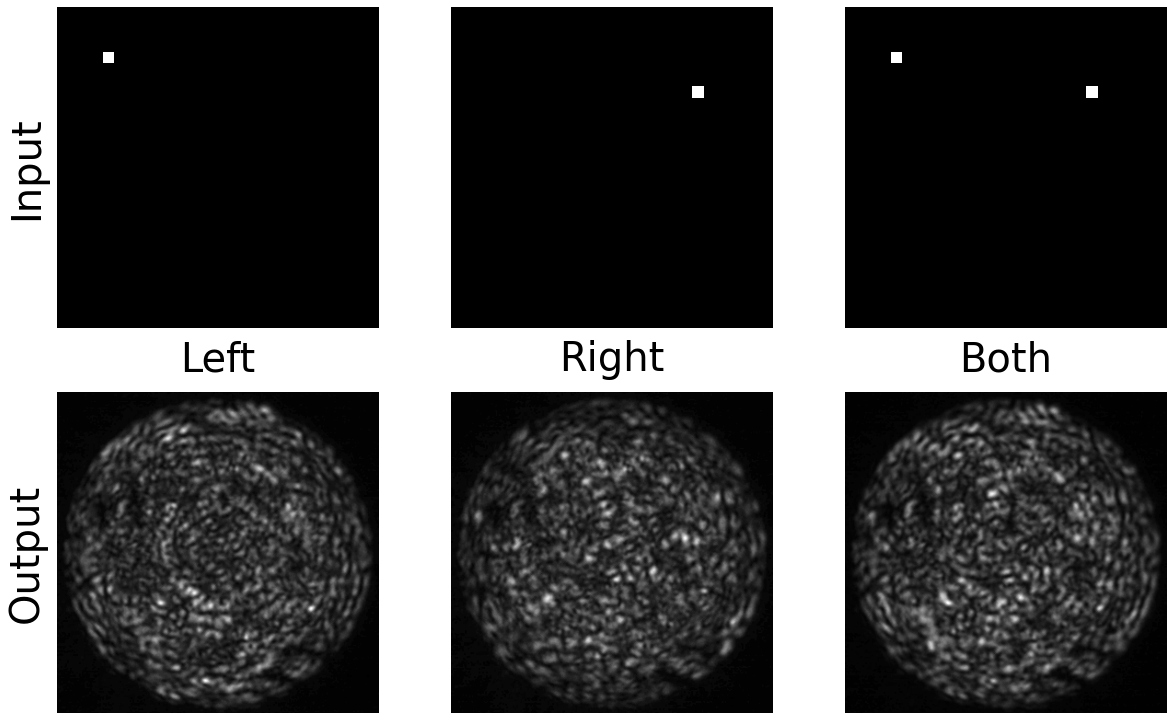

In [2]:
%%time

file_location = 'Figure_1.pkl'
f = open(file_location,'rb')
figure = pickle.load(f)        
f.close()

dx_in = figure['Input']['Right'].astype('float32')
sx_in = figure['Input']['Left'].astype('float32')
bo_in = figure['Input']['Both'].astype('float32')

dx = figure['Output']['Right'].astype('float32')
sx = figure['Output']['Left'].astype('float32')
bo = figure['Output']['Both'].astype('float32')

rows, cols = 2, 3
x_size, y_size = 40, 40
x_pad, y_pad = 12, 10

def add_to_plot(img, rows, cols, idx, 
                x_label=None, y_label=None, x_size=None, y_size=None, x_pad=None, y_pad=None,):
    plt.subplot(rows, cols, idx)
    plt.imshow(img)
    if x_label: plt.xlabel(x_label, size = x_size, labelpad = x_pad)
    if y_label: plt.ylabel(y_label, size = y_size, labelpad = y_pad)
    plt.xticks([]); plt.yticks([])
    
# Set subplot size
f, ax_arr = plt.subplots(rows, cols, figsize=(20, 13))

# LEFT
add_to_plot(sx_in, rows, cols, 1, 
            x_label='Left', y_label='Input', x_size=x_size, y_size=y_size, x_pad=x_pad, y_pad=y_pad)
add_to_plot(sx, rows, cols, 4, y_label='Output', y_size=y_size, y_pad=y_pad)
# RIGHT
add_to_plot(dx_in, rows, cols, 2, x_label='Right', x_size=x_size, x_pad=x_pad)
add_to_plot(dx, rows, cols, 5)
# BOTH
add_to_plot(bo_in, rows, cols, 3, x_label='Both', x_size=x_size, x_pad=x_pad)
add_to_plot(bo, rows, cols, 6)

f.savefig(f'figures/single_pixel_responses.png', bbox_inches='tight')
K.clear_session()

## Figure 2 - Training using Inputs and Outputs from MNIST

AttributeError: '_io.BufferedReader' object has no attribute 'savefig'

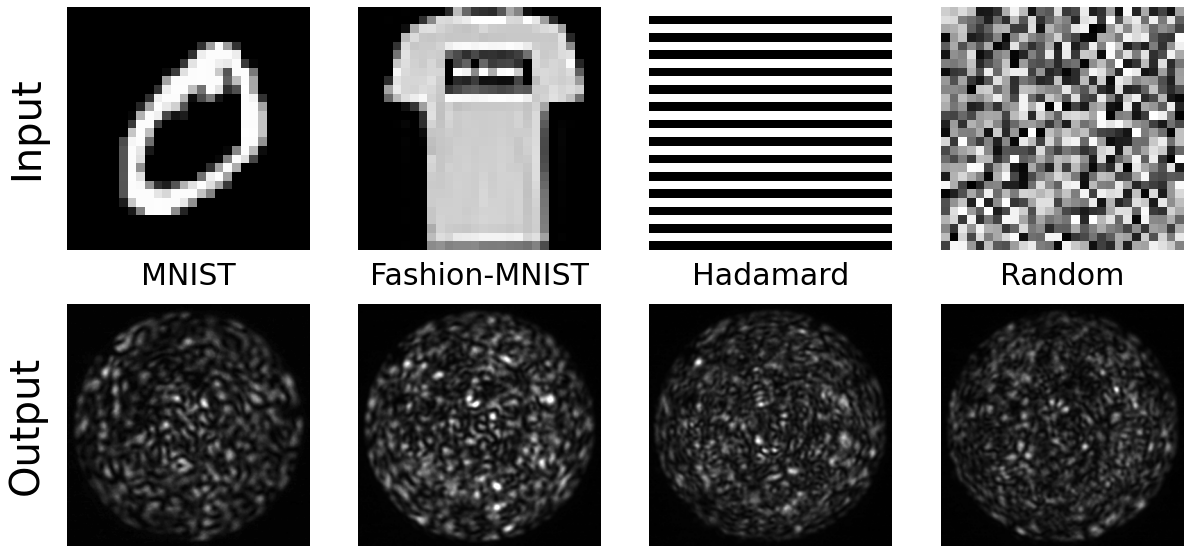

In [3]:
%%time
ex = 1

file_location = 'Figure_3.pkl'
f = open(file_location,'rb')
figure = pickle.load(f)        
f.close()


mnist_in = figure['Input']['MNIST'].astype('float32')
fashion_in = figure['Input']['Fashion-MNIST'].astype('float32')
hadamard_in = figure['Input']['Hadamard'].astype('float32')
random_in = figure['Input']['Random'].astype('float32')

mnist = figure['Output']['MNIST'].astype('float32')
fashion = figure['Output']['Fashion-MNIST'].astype('float32')
hadamard = figure['Output']['Hadamard'].astype('float32')
random = figure['Output']['Random'].astype('float32')


rows, cols = 2, 4
x_size, y_size = 30, 40
x_pad, y_pad = 12, 20

# Set subplot size
f1, ax_arr1 = plt.subplots(rows, cols, figsize=(20, 10))


def add_to_plot(img, rows, cols, idx, 
                x_label=None, y_label=None, x_size=None, y_size=None, x_pad=None, y_pad=None,):
    plt.subplot(rows, cols, idx)
    plt.imshow(img)
    if x_label: plt.xlabel(x_label, size = x_size, labelpad = x_pad)
    if y_label: plt.ylabel(y_label, size = y_size, labelpad = y_pad)
    plt.xticks([]); plt.yticks([])

    
# MNIST
add_to_plot(mnist_in, rows, cols, 1, 
            x_label='MNIST', y_label='Input', x_size=x_size, y_size=y_size, x_pad=x_pad, y_pad=y_pad)
add_to_plot(mnist, rows, cols, 5, y_label='Output', y_size=y_size, y_pad=y_pad)
# Fashion-MNIST
add_to_plot(fashion_in, rows, cols, 2, x_label='Fashion-MNIST', x_size=x_size, x_pad=x_pad)
add_to_plot(fashion, rows, cols, 6)
# Hadamard
add_to_plot(hadamard_in, rows, cols, 3, x_label='Hadamard', x_size=x_size, x_pad=x_pad)
add_to_plot(hadamard, rows, cols, 7)
# Random
add_to_plot(random_in, rows, cols, 4, x_label='Random', x_size=x_size, x_pad=x_pad)
add_to_plot(random, rows, cols, 8)

f.savefig(f'figures/input_output_examples.png', bbox_inches='tight')
K.clear_session()

## Training Model
### ML Parameters

In [4]:
lamb = 1.0
epochs = 5
lr = 1e-5
batch_size = 64

### Load data

Loading digi ...
Loading fash ...
Loading rand ...
Loading fash_test ...
Loading digi_test ...
Loading punc ...


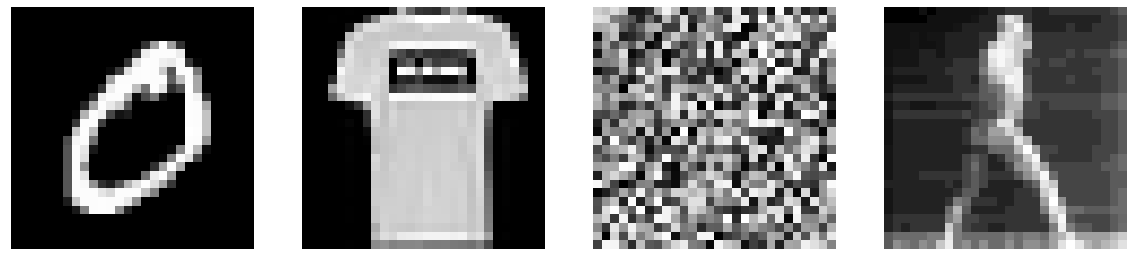

In [5]:
out_dim = 28
speckle_dim = 112 #56
image_dim = speckle_dim
Use_root    = False
phase_shift = False


file_location = 'Data_1m.h5'
hf = h5py.File(file_location , 'r')



# Original/input image filenames
orig_img_filenames =  {'digi': 'Training/Original_images/MNIST',
                      'fash': 'Training/Original_images/Fashion-MNIST',
                      'rand': 'Training/Original_images/Random Patterns',
                 'fash_test': 'Testing/Original_images/MNIST',
                 'digi_test': 'Testing/Original_images/Fashion-MNIST',
                      'punc': 'Testing/Original_images/Muybridge Punch'}

orig_imgs = {dataset: None for dataset in orig_img_filenames}


for dataset, filename in orig_img_filenames.items():
    # Load
    fl = hf[filename]
    orig_imgs[dataset] =  np.array(fl)


y_train = np.concatenate((orig_imgs['digi'],
                          orig_imgs['fash'],
                          orig_imgs['rand'],
                         ))

y_train = np.squeeze(y_train.reshape(-1, 28*28, 1))

y_test = np.concatenate((orig_imgs['digi_test'],
                         orig_imgs['fash_test'],))

y_test = np.squeeze(y_test.reshape(-1, 28*28, 1))


## Example of each dataset
rows, cols = 1, len(orig_img_filenames)-2 # exclude test sets
f, ax_arr = plt.subplots(rows, cols, figsize=(20, 10))
ex = 1

i = 1
for name in (name for name in orig_img_filenames if 'test' not in name):
    plt.subplot(rows, cols, i)
    plt.imshow(orig_imgs[name][ex].reshape(28,28))
    axes_off()
    i+=1


speckle_img_filenames =  {'digi': 'Training/Speckle_images/MNIST',
                      'fash': 'Training/Speckle_images/Fashion-MNIST',
                      'rand': 'Training/Speckle_images/Random Patterns',
                 'fash_test': 'Testing/Speckle_images/MNIST',
                 'digi_test': 'Testing/Speckle_images/Fashion-MNIST',
                      'punc': 'Testing/Speckle_images/Muybridge Punch'}

data_dict = {dataset: None for dataset in speckle_img_filenames}

for dataset, filename in speckle_img_filenames.items():
    print(f"Loading {dataset} ...")
    # Load
    fl = hf[filename]
    data_dict[dataset] =  np.array(fl)
    Data_resize = np.reshape(data_dict[dataset], (data_dict[dataset].shape[0],224,224) )
    Data_temp = np.zeros((data_dict[dataset].shape[0],speckle_dim*speckle_dim))
    for im in range(data_dict[dataset].shape[0]):

        Data_temp[im] = np.reshape(cv2.resize(Data_resize[im], dsize=(speckle_dim, speckle_dim), interpolation=cv2.INTER_AREA), (speckle_dim*speckle_dim))
    
    data_dict[dataset] = Data_temp            
    del Data_temp, Data_resize
    gc.collect()

x_train = np.concatenate((data_dict['digi'],
                          data_dict['fash'],
                          data_dict['rand'],
                         ))

x_test = np.concatenate((data_dict['digi_test'], data_dict['fash_test'],))


x_train_ch = real_to_channels_np(x_train.astype('float32'))
x_test_ch  = real_to_channels_np(x_test.astype('float32'))



hf.close()

### Since training dataset is taken using SLM, applying appropriate non-linear transform


In [6]:
from scipy import interpolate
experimentalAmp   = np.load('amplitude.npy')
experimentalPhase = np.load('phase.npy')
experimentalPhase = np.append(experimentalPhase, experimentalPhase[-2] ) # add in missing datapoint

x1 = np.arange(0.0,101.0)/100.0
x2 = np.arange(0.0,101.0)/100.0
print(len(experimentalPhase), len(x2))
testx = np.arange(0.0,100.0,0.5)/100.0
fSLMamp = interpolate.interp1d(x1, experimentalAmp/np.max(experimentalAmp))
fSLMphase = interpolate.interp1d(x2, experimentalPhase)


print(np.min(y_train), np.max(y_train))
y_train_phase = fSLMphase(y_train)*255.0
y_test_phase  = fSLMphase(y_test)*255.0
y_train       = fSLMamp(y_train)*255.0
y_test        = fSLMamp(y_test)*255.0
print(np.min(y_train), np.max(y_train))

101 101
0.0 1.0
3.113248752079867 255.0


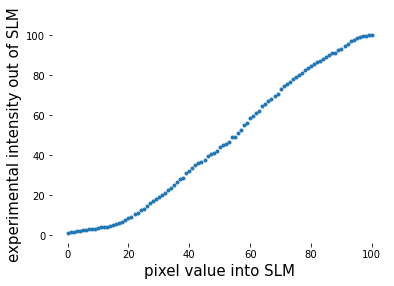

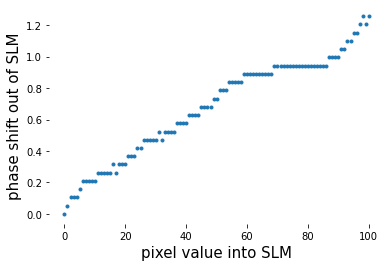

In [7]:
#SLM data for ideal obtained data; not experimental data obtained for lab that does not use SLM

import math
plt.figure()
plt.plot(100.0*experimentalAmp/np.max(experimentalAmp),'.')
#plt.plot(testx, fSLMamp(testx),'-k')
plt.xlabel('pixel value into SLM',fontsize=15)
plt.ylabel('experimental intensity out of SLM',fontsize=15)
plt.savefig(f'figures/phaseSLM.png', bbox_inches='tight')
plt.figure()
plt.plot(experimentalPhase*math.pi,'.')
#plt.plot(testx, fSLMphase(testx),'-k')
plt.ylabel('phase shift out of SLM',fontsize=15)
plt.xlabel('pixel value into SLM',fontsize=15)
plt.savefig(f'figures/ampSLM.png', bbox_inches='tight')


In [8]:
class Hadamard2(Layer):
    # creates a layer for elementwise multiplying every element of a vector by another weight vector
    # assumes input is complex in separate real and imaginary channels
    def __init__(self, kernel_constraint=None, **kwargs):
        super(Hadamard2, self).__init__(**kwargs)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
 
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(1,input_shape[1]),
                                      initializer=keras.initializers.Constant(value=1.0),
                                      constraint=self.kernel_constraint,
                                      trainable=True)
        super(Hadamard2, self).build(input_shape)  # Be sure to call this somewhere!
 
    def call(self, x):
        if tf.keras.backend.ndim(x) == 3:
            return complex_to_channels(channels_to_complex(x) * 
                                       tf.complex(self.kernel, 0*self.kernel))
        else:
            return x*self.kernel
        
    def get_config(self):
        config = {
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint)
        }
        base_config = super(Hadamard2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
 
    def compute_output_shape(self, input_shape):
        return input_shape


### Single Layer - Real, No Regularisation

In [9]:
inp_1 = Input(shape=(image_dim*image_dim, 2))
lay_1 = Amplitude()(inp_1)
lay_1 = Reshape((image_dim*image_dim,))(lay_1)
out_1 = Dense(28*28, use_bias=False)(lay_1)
# learn the amplitude attenuation function
out_1 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(out_1)
mod_1 = Model(inputs=inp_1, outputs=[out_1])

mod_1.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12544, 2)]        0         
                                                                 
 amplitude (Amplitude)       (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 784)               9834496   
                                                                 
 hadamard2 (Hadamard2)       (None, 784)               784       
                                                                 
Total params: 9,835,280
Trainable params: 9,835,280
Non-trainable params: 0
_________________________________________________________________


C:\Users\madhu\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### Single Layer - Real, L2 Weight Regularisation

In [10]:
lamb = 0.03

inp_2 = Input(shape=(image_dim*image_dim, 2))
lay_2 = Amplitude()(inp_2)
lay_2 = Reshape((image_dim*image_dim,))(lay_2)
out_2 = Dense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(lay_2)
# learn the amplitude attenuation function
out_2 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(out_2)
mod_2 = Model(inputs=inp_2, outputs=[out_2])

mod_2.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12544, 2)]        0         
                                                                 
 amplitude_1 (Amplitude)     (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 12544)             0         
                                                                 
 dense_1 (Dense)             (None, 784)               9834496   
                                                                 
 hadamard2_1 (Hadamard2)     (None, 784)               784       
                                                                 
Total params: 9,835,280
Trainable params: 9,835,280
Non-trainable params: 0
_________________________________________________________________


### Single Layer - Complex, No Regularisation

In [11]:
inp_3 = Input(shape=(image_dim*image_dim, 2))
lay_3 = ComplexDense(28*28, use_bias=False)(inp_3)
# learn the amplitude attenuation function
out_3 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_3)
out_3 = Amplitude()(out_3)
mod_3 = Model(inputs=inp_3, outputs=[out_3])

mod_3.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12544, 2)]        0         
                                                                 
 complex_dense (ComplexDense  (None, 784, 2)           19668992  
 )                                                               
                                                                 
 hadamard2_2 (Hadamard2)     (None, 784, 2)            784       
                                                                 
 amplitude_2 (Amplitude)     (None, 784)               0         
                                                                 
Total params: 19,669,776
Trainable params: 19,669,776
Non-trainable params: 0
_________________________________________________________________


### Single Layer - Complex, L2 Weight Regularisation

In [12]:
inp_4 = Input(shape=(image_dim*image_dim, 2))
lay_4 = ComplexDense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(inp_4)
had_4 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_4)
out_4 = Amplitude()(had_4)
#out_ph4 = Phase()(had_4)
mod_4 = Model(inputs=inp_4, outputs=out_4)#, out_ph4])

mod_4.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
mod_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 12544, 2)]        0         
                                                                 
 complex_dense_1 (ComplexDen  (None, 784, 2)           19668992  
 se)                                                             
                                                                 
 hadamard2_3 (Hadamard2)     (None, 784, 2)            784       
                                                                 
 amplitude_3 (Amplitude)     (None, 784)               0         
                                                                 
Total params: 19,669,776
Trainable params: 19,669,776
Non-trainable params: 0
_________________________________________________________________


### Single Layer - Complex, Semi-Unitary Regularisation

In [13]:
inp_5 = Input(shape=(image_dim*image_dim, 2))
lay_5 = ComplexDense(28*28, use_bias=False, kernel_regularizer=UnitaryReg(lamb))(inp_5)
out_5 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=10.0, 
                                                                     rate=1.0, axis=0))(lay_5)
out_5 = Amplitude()(lay_5)
mod_5 = Model(inputs=inp_5, outputs=[out_5])

mod_5.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 12544, 2)]        0         
                                                                 
 complex_dense_2 (ComplexDen  (None, 784, 2)           19668992  
 se)                                                             
                                                                 
 amplitude_4 (Amplitude)     (None, 784)               0         
                                                                 
Total params: 19,668,992
Trainable params: 19,668,992
Non-trainable params: 0
_________________________________________________________________


In [14]:
#now try UnitaryReg2 (transposed unitary constraint)
inp_52 = Input(shape=(image_dim*image_dim, 2))
lay_5 = ComplexDense(28*28, use_bias=False, 
                     #kernel_initializer=RandomUnitaryNormal(),
                     kernel_regularizer=UnitaryReg2(lamb*10)
                    )(inp_52)
out_5 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=10.0, 
                                                                     rate=1.0, axis=0))(lay_5)
out_52 = Amplitude()(lay_5)
mod_52 = Model(inputs=inp_52, outputs=[out_52])

mod_52.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_52.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 12544, 2)]        0         
                                                                 
 complex_dense_3 (ComplexDen  (None, 784, 2)           19668992  
 se)                                                             
                                                                 
 amplitude_5 (Amplitude)     (None, 784)               0         
                                                                 
Total params: 19,668,992
Trainable params: 19,668,992
Non-trainable params: 0
_________________________________________________________________


### Single Layer - Complex, Square Unitary Regularisation

In [15]:
T_dim = int(speckle_dim/2)

inp_5s    = Input(shape=(image_dim*image_dim, 2))
reshape_1 = Reshape((speckle_dim,speckle_dim,2))(inp_5s)
pool_1    = AveragePooling2D((2,2))(reshape_1)
reshape_2 = Reshape((T_dim**2,2))(pool_1)
lay_5 = ComplexDense(T_dim**2, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(reshape_2)

#lay_5     = ComplexDense(T_dim**2, use_bias=False, kernel_initializer=RandomUnitaryNormal(), kernel_regularizer=UnitaryReg(lamb*10))(reshape_2)
reshape_3 = Reshape((T_dim,T_dim,2))(lay_5)
out_5s    = AveragePooling2D((2,2))(reshape_3)
out_5s    = Reshape((out_dim*out_dim,2))(out_5s)
#out_5s = AveragePooling2D((2,2))(out_5s)
out_5s    = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=10.0, 
                                                                     rate=10.0, axis=0))(out_5s)
out_5s = Amplitude()(out_5s)
#out_5s = Flatten()(out_5s)
#had_layer = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.00001, max_value=1.0, 
#                                                                         rate=1.0, axis=0))
#out_5s = had_layer(out_5s)


mod_5s = Model(inputs=inp_5s, outputs=[out_5s])

mod_5s.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_5s.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 12544, 2)]        0         
                                                                 
 reshape_2 (Reshape)         (None, 112, 112, 2)       0         
                                                                 
 average_pooling2d (AverageP  (None, 56, 56, 2)        0         
 ooling2D)                                                       
                                                                 
 reshape_3 (Reshape)         (None, 3136, 2)           0         
                                                                 
 complex_dense_4 (ComplexDen  (None, 3136, 2)          19668992  
 se)                                                             
                                                                 
 reshape_4 (Reshape)         (None, 56, 56, 2)         0   

###Single, square, non-Unitary regularisation

In [16]:
T_dim = int(speckle_dim/2)

inp_5snu    = Input(shape=(image_dim*image_dim, 2))
reshape_1 = Reshape((speckle_dim,speckle_dim,2))(inp_5snu)
pool_1    = AveragePooling2D((2,2))(reshape_1)
reshape_2 = Reshape((T_dim**2,2))(pool_1)
#lay_5 = ComplexDense(T_dim**2, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(reshape_2)

lay_5     = ComplexDense(T_dim**2, use_bias=False)(reshape_2)
reshape_3 = Reshape((T_dim,T_dim,2))(lay_5)
out_5snu    = AveragePooling2D((2,2))(reshape_3)
out_5snu    = Reshape((out_dim*out_dim,2))(out_5snu)
#out_5s = AveragePooling2D((2,2))(out_5s)
out_5snu    = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=10.0, axis=0))(out_5snu)
out_5snu = Amplitude()(out_5snu)
#out_5s = Flatten()(out_5s)
#had_layer = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.00001, max_value=1.0, 
#                                                                         rate=1.0, axis=0))
#out_5s = had_layer(out_5s)


mod_5snu = Model(inputs=inp_5snu, outputs=[out_5snu])

mod_5snu.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_5snu.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 12544, 2)]        0         
                                                                 
 reshape_6 (Reshape)         (None, 112, 112, 2)       0         
                                                                 
 average_pooling2d_2 (Averag  (None, 56, 56, 2)        0         
 ePooling2D)                                                     
                                                                 
 reshape_7 (Reshape)         (None, 3136, 2)           0         
                                                                 
 complex_dense_5 (ComplexDen  (None, 3136, 2)          19668992  
 se)                                                             
                                                                 
 reshape_8 (Reshape)         (None, 56, 56, 2)         0   

### Single Layer - Complex, Multi-res training

In [17]:
inp_6 = Input(shape=(image_dim*image_dim, 2))
lay_6 = ComplexDense(28*28, use_bias=False, kernel_regularizer=UnitaryAndL2Reg(l_u=lamb/10, l_a=lamb/3))(inp_6)
lay_6 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_6)
reshape_1 = Reshape((28,28,2))(lay_6)
pool1 = AveragePooling2D((2,2))(reshape_1)
pool2 = AveragePooling2D((4,4))(reshape_1)
flatten1 = Reshape((14*14,2))(pool1)
flatten2 = Reshape((7*7,2))(pool2)
out1 = Amplitude()(lay_6)
out2 = Amplitude()(flatten1)
out3 = Amplitude()(flatten2)

mod_6 = Model(inputs=inp_6, outputs=[out1, out2, out3])

mod_6.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
mod_6.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 12544, 2)]   0           []                               
                                                                                                  
 complex_dense_6 (ComplexDense)  (None, 784, 2)      19668992    ['input_9[0][0]']                
                                                                                                  
 hadamard2_8 (Hadamard2)        (None, 784, 2)       784         ['complex_dense_6[0][0]']        
                                                                                                  
 reshape_10 (Reshape)           (None, 28, 28, 2)    0           ['hadamard2_8[0][0]']            
                                                                                            

In [18]:
inp_6noreg = Input(shape=(image_dim*image_dim, 2))
lay_6 = ComplexDense(28*28, use_bias=False)(inp_6noreg)
lay_6 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_6)
reshape_1 = Reshape((28,28,2))(lay_6)
pool1 = AveragePooling2D((2,2))(reshape_1)
pool2 = AveragePooling2D((4,4))(reshape_1)
flatten1 = Reshape((14*14,2))(pool1)
flatten2 = Reshape((7*7,2))(pool2)
out1_noreg = Amplitude()(lay_6)
out2_noreg = Amplitude()(flatten1)
out3_noreg = Amplitude()(flatten2)

mod_6noreg = Model(inputs=inp_6noreg, outputs=[out1_noreg, out2_noreg, out3_noreg])

mod_6noreg.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
mod_6noreg.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 12544, 2)]   0           []                               
                                                                                                  
 complex_dense_7 (ComplexDense)  (None, 784, 2)      19668992    ['input_10[0][0]']               
                                                                                                  
 hadamard2_9 (Hadamard2)        (None, 784, 2)       784         ['complex_dense_7[0][0]']        
                                                                                                  
 reshape_13 (Reshape)           (None, 28, 28, 2)    0           ['hadamard2_9[0][0]']            
                                                                                            

In [19]:
inp_6l2 = Input(shape=(image_dim*image_dim, 2))
lay_6 = ComplexDense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(inp_6l2)
lay_6 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_6)
reshape_1 = Reshape((28,28,2))(lay_6)
pool1 = AveragePooling2D((2,2))(reshape_1)
pool2 = AveragePooling2D((4,4))(reshape_1)
flatten1 = Reshape((14*14,2))(pool1)
flatten2 = Reshape((7*7,2))(pool2)
out1l2 = Amplitude()(lay_6)
out2l2 = Amplitude()(flatten1)
out3l2 = Amplitude()(flatten2)

mod_6l2 = Model(inputs=inp_6l2, outputs=[out1l2, out2l2, out3l2])

mod_6l2.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
mod_6l2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 12544, 2)]   0           []                               
                                                                                                  
 complex_dense_8 (ComplexDense)  (None, 784, 2)      19668992    ['input_11[0][0]']               
                                                                                                  
 hadamard2_10 (Hadamard2)       (None, 784, 2)       784         ['complex_dense_8[0][0]']        
                                                                                                  
 reshape_16 (Reshape)           (None, 28, 28, 2)    0           ['hadamard2_10[0][0]']           
                                                                                           

In [20]:
from copy import copy
from matplotlib import colors

def eval_and_display(model, model_name, x_vals, y_vals, square_results=False, out_dim=28, vmax=255.0):
    # Evaluate MSE
    MSE = model.evaluate(x_vals, y_vals, batch_size=1000)[1]
    print(f"MSE for {model_name} = {MSE}\n")
    with open("tables/MSE.txt", "a") as file:
        file.write(f'\\verb+{model_name}+ & {MSE:.4f}  \\\\\n')
    
    pred_test = model.predict(x_vals)
    if type(pred_test) == list:
        pred_test = pred_test[0]
    if square_results:
        pred_test = pred_test ** 2
    
    rows, cols = 4, 4
    f, ax_arr = plt.subplots(rows, cols, figsize=(20, 20))

    i = 1
    offsets = [0, 3000-2*cols]
    
    palette = copy(plt.cm.gray)
    palette.set_over('r', 1.0)
    palette.set_under('g', 1.0)
    palette.set_bad('b', 1.0)

    for row in range(1,rows+1,2):
        for col in range(cols):
            i = (row-1)*cols + (col+1)
            offset = offsets[(row-1)//2]
            if row>1 and col>2: offset+=4

            plt.subplot(rows,cols,i)
            if type(y_vals) == list:
                this_image = y_vals[0][offset+i-1].reshape(out_dim,out_dim)
            else:
                this_image = y_vals[offset+i-1].reshape(out_dim,out_dim)        
            plt.imshow(this_image,
                      norm=colors.Normalize(vmin=0.0, vmax=vmax, clip=False))
            axes_off()

            plt.subplot(rows,cols,i+cols)
            plt.imshow(pred_test[offset+i-1].reshape(out_dim,out_dim),
                      norm=colors.Normalize(vmin=0.0, vmax=vmax, clip=False))
            axes_off()

    f.savefig(f'figures/model_comparison_{model_name}.png', bbox_inches='tight')
    
def energy(x):
    e = np.linalg.norm(x,axis=1)
    return e

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=lr/1e3,
                              verbose=1,)

early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=10)

In [21]:
#cells below take time to run

In [22]:
LaTeX_table =  ("\\begin{table}\n"
                "\\caption{Model comparisons where each single layer model with approximately "
                f"{int(round(mod_2.count_params()/1_000_000))} million parameters was trained for "
                f"${epochs}$ epochs, on a speckle resolution of "
                f"${image_dim}\\times{image_dim}$, and with "
                f"$\\lambda={lamb}$ where the model was regularised.}}"
                "\\label{tab:models}\n"
                "\\centering\n"
                "\\begin{tabular}{ll}\n"
                "\\toprule\n"
                "\\multicolumn{1}{c}{Model}\\\\\n"
                "\\cmidrule(r){1-1}\n"
                "Name & MSE \\\\ \n\\midrule\n")
with open("tables/MSE.txt", "w") as file:
        file.write(LaTeX_table)

Epoch 1/5
688/688 [==============================] - 465s 673ms/step - loss: 9382.7705 - amplitude_14_loss: 5125.4282 - amplitude_15_loss: 2059.6133 - amplitude_16_loss: 2197.2075 - amplitude_14_mse: 5125.4282 - amplitude_15_mse: 2059.6133 - amplitude_16_mse: 2197.2075 - val_loss: 5841.7686 - val_amplitude_14_loss: 2523.7271 - val_amplitude_15_loss: 1542.0173 - val_amplitude_16_loss: 1775.1365 - val_amplitude_14_mse: 2523.7271 - val_amplitude_15_mse: 1542.0173 - val_amplitude_16_mse: 1775.1365 - lr: 1.0000e-05
Epoch 2/5
688/688 [==============================] - 447s 650ms/step - loss: 7570.9521 - amplitude_14_loss: 4452.7612 - amplitude_15_loss: 1489.6357 - amplitude_16_loss: 1627.3336 - amplitude_14_mse: 4452.7612 - amplitude_15_mse: 1489.6357 - amplitude_16_mse: 1627.3336 - val_loss: 4785.2417 - val_amplitude_14_loss: 2125.7288 - val_amplitude_15_loss: 1208.7058 - val_amplitude_16_loss: 1449.2499 - val_amplitude_14_mse: 2125.7288 - val_amplitude_15_mse: 1208.7058 - val_amplitude_16_

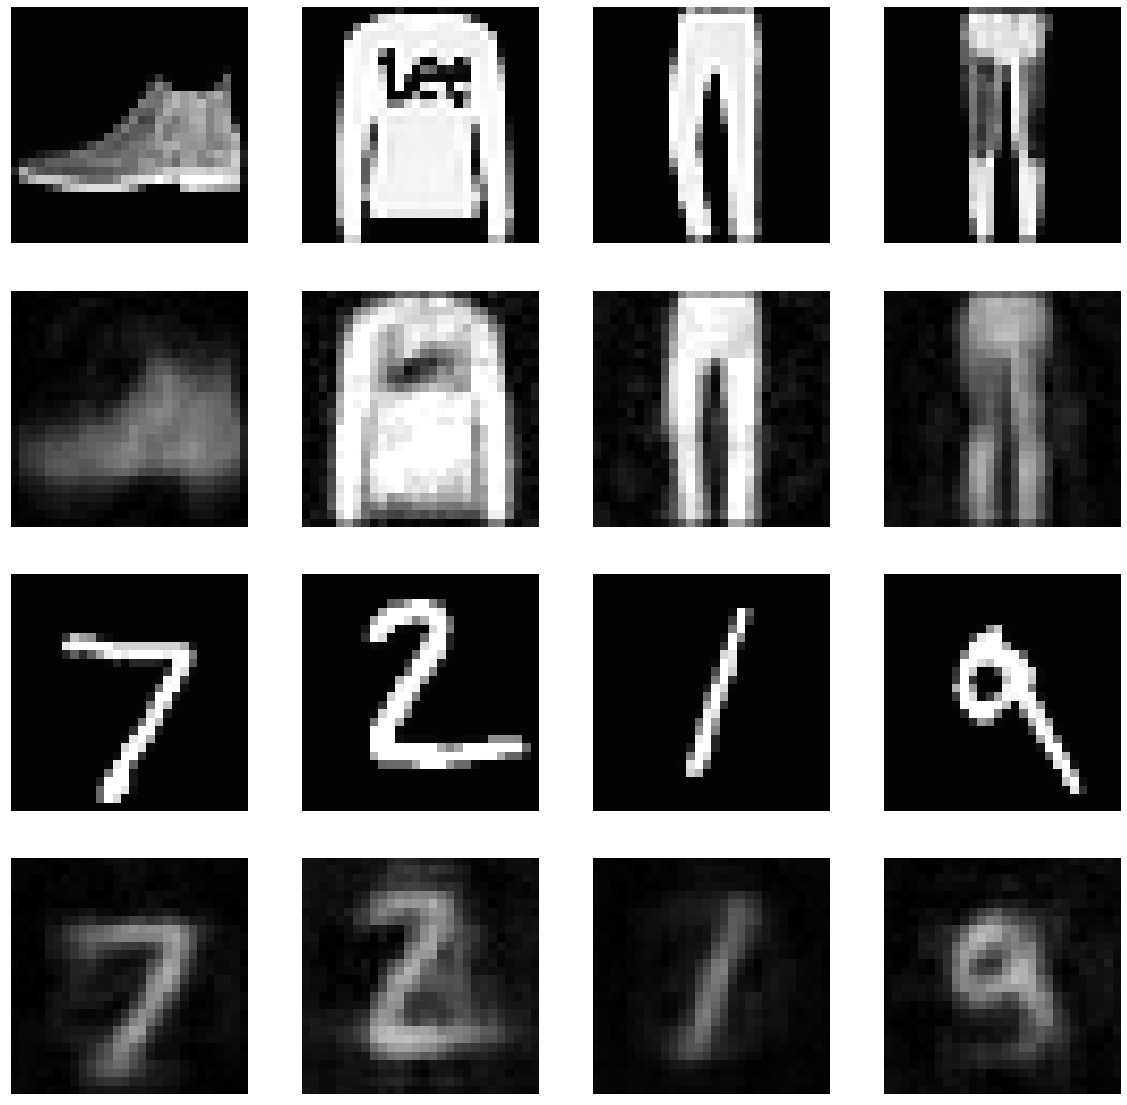

In [24]:
model_name = 'comp_pyramid_l2'
weights_filepath = f'weights/{model_name}.h5'
model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                            verbose=0, save_best_only=False, 
                            save_weights_only=True, mode='auto',
                            period=1)
t_b = TensorBoard(log_dir=f'./logs/{model_name}', histogram_freq=0, batch_size=32, 
                  write_graph=False, write_grads=False, write_images=False,
                  embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
#model.load_weights(weights_filepath)
mod_6l2.fit(x_train_ch,
          [y_train_p[0], y_train_p[1], y_train_p[2]],
          validation_data = (x_test_ch, [y_test_p[0], y_test_p[1], y_test_p[2]]),
          epochs = epochs,
          batch_size = batch_size,
          callbacks = [model_chk, reduce_lr, t_b, early_stop],
          shuffle = True,
         )
eval_and_display(mod_6l2, model_name, x_test_ch, [y_test_p[0], y_test_p[1], y_test_p[2]], vmax= 255.0)

6/6 [==============================] - 10s 2s/step - loss: 3678.8154 - amplitude_14_loss: 1690.5758 - amplitude_15_loss: 878.8198 - amplitude_16_loss: 1106.0211 - amplitude_14_mse: 1690.5758 - amplitude_15_mse: 878.8198 - amplitude_16_mse: 1106.0211
MSE for comp_pyramid_l2 = 1690.5758056640625



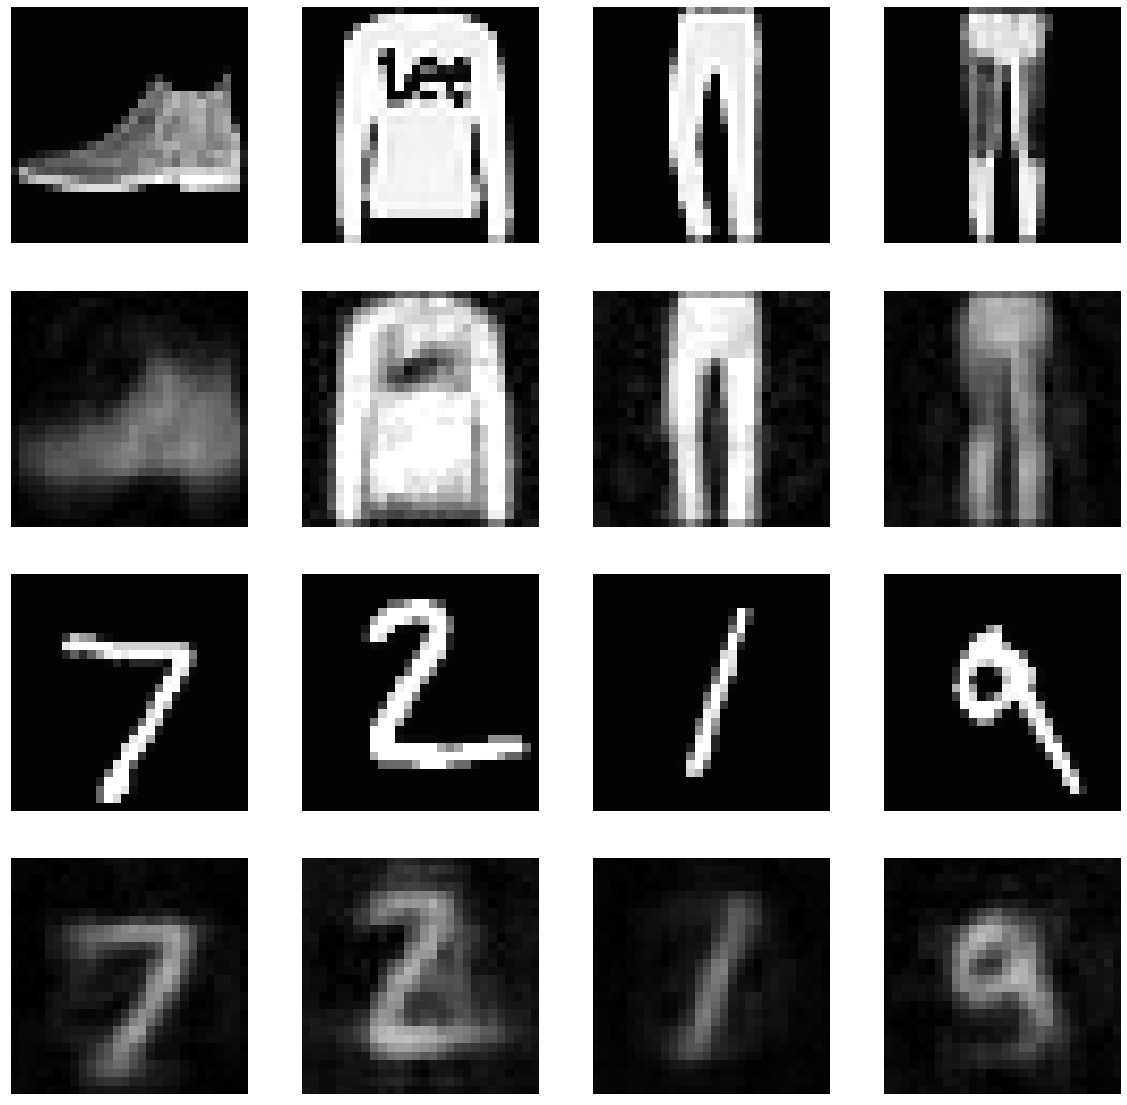

In [25]:
eval_and_display(mod_6l2, model_name, x_test_ch, [y_test_p[0], y_test_p[1], y_test_p[2]], vmax= 255.0)

## MSE

In [27]:
#Reshape output to be compatible with SSIM
y_train = np.expand_dims(y_train, -1).reshape(-1, 28, 28, 1)
y_test = np.expand_dims(y_test, -1).reshape(-1, 28, 28, 1)

### Model trained to convergence with MSE

In [28]:
inp_4 = Input(shape=(image_dim*image_dim, 2))
lay_4 = ComplexDense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(inp_4)
had_4 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_4)
out_4 = Amplitude()(had_4)
#out_ph4 = Phase()(had_4)
mod_4 = Model(inputs=inp_4, outputs=out_4)#, out_ph4])

mod_4.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
mod_4.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 12544, 2)]        0         
                                                                 
 complex_dense_9 (ComplexDen  (None, 784, 2)           19668992  
 se)                                                             
                                                                 
 hadamard2_11 (Hadamard2)    (None, 784, 2)            784       
                                                                 
 amplitude_17 (Amplitude)    (None, 784)               0         
                                                                 
Total params: 19,669,776
Trainable params: 19,669,776
Non-trainable params: 0
_________________________________________________________________


In [30]:
# loading trained model: path:- madhu/Python/weights/comp_pyramid_l2
model = mod_4
model_name = "comp_pyramid_l2"
weights_filepath = f'{model_name}.h5'
model.load_weights(weights_filepath)

In [ ]:
%%time
epochs = 5
# Setup callbacks
model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                            verbose=0, save_best_only=False, 
                            save_weights_only=True, mode='auto',
                            period=1)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=lr/1e3,
                              verbose=1,)

t_b = TensorBoard(log_dir=f'./logs/{model_name}', histogram_freq=0, batch_size=32, 
                  write_graph=False, write_grads=False, write_images=False,
                  embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

model.load_weights(weights_filepath)
# Train
model.fit(x_train_ch, 
          y_train,
          validation_data = (x_test_ch, y_test),
          epochs = epochs,
          batch_size = batch_size,
          callbacks = [model_chk, reduce_lr, t_b, early_stop],
          shuffle = True,
         )

In [31]:
model_name = "MSE"
eval_and_display(model, model_name, x_test_ch, y_test, vmax= 255.0)
model_name = "comp_pyramid_l2"

ValueError: in user code:

    File "C:\Users\madhu\anaconda3\lib\site-packages\keras\engine\training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\madhu\anaconda3\lib\site-packages\keras\engine\training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\madhu\anaconda3\lib\site-packages\keras\engine\training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\madhu\anaconda3\lib\site-packages\keras\engine\training.py", line 1473, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\madhu\anaconda3\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "C:\Users\madhu\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\madhu\anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\madhu\anaconda3\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\madhu\anaconda3\lib\site-packages\keras\losses.py", line 1329, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 1000 and 28 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model_11/amplitude_17/Abs, IteratorGetNext:1)' with input shapes: [1000,784], [1000,28,28,1].


### Training the same model further using SSIM

In [32]:
epochs = 5
inp_7 = Input(shape=(image_dim*image_dim, 2))
lay_7 = ComplexDense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(inp_7)
had_7 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_7)
lay_7 = Amplitude()(had_7)
out_7 = Reshape((28,28,1))(lay_7) # reshape for compatability with SSIM
mod_7 = Model(inputs=inp_7, outputs=[out_7])

mod_7.load_weights(weights_filepath) # Load weights from the model trained with just MSE
mod_7.compile(optimizer=SGD(lr=lr), loss=DSSIMObjective(), metrics=['mse',])
mod_7.summary()

NameError: name 'DSSIMObjective' is not defined

In [33]:
%%time

model = mod_7
model_name = "MSE_then_SSIM"
weights_filepath = f'weights/{model_name}.h5'
model.load_weights(weights_filepath)
# Setup callbacks
model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                            verbose=0, save_best_only=False, 
                            save_weights_only=True, mode='auto',
                            period=1)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=lr/1e3,
                              verbose=1,)

t_b = TensorBoard(log_dir=f'./logs/{model_name}', histogram_freq=0, batch_size=32, 
                  write_graph=False, write_grads=False, write_images=False,
                  embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

# Train
model.fit(x_train_ch, 
          np.reshape(y_train, (np.shape(y_train)[0],28, 28,1)),
          validation_data = (x_test_ch, np.reshape( y_test, (np.shape(y_test)[0],28, 28,1))),
          epochs = epochs,
          batch_size = batch_size,
          callbacks = [model_chk, reduce_lr, t_b, early_stop],
          shuffle = True,
         )
eval_and_display(model, model_name, x_test_ch, np.reshape( y_test, (np.shape(y_test)[0],28, 28,1)), vmax= 255.0)


OSError: Unable to open file (unable to open file: name = 'weights/MSE_then_SSIM.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [34]:
eval_and_display(model, model_name, x_test_ch, np.reshape( y_test, (np.shape(y_test)[0],28, 28,1)), vmax= 255.0)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

## Speckle resolution on reconstructed image

In [35]:
epochs = 5
lr = 1e-5
batch_size = 32
lamb = 0.03
image_dims = [14*(2**x) for x in range(5)]

rows = 3
cols = len(image_dims)
ex = 3001 # "Lee" top
images = [None]*cols*rows

#### Loading Phase and Amplitude & Hadamard Layer

In [36]:
#Import phase and amplitude
from scipy import interpolate
experimentalAmp   = np.load('amplitude.npy')
experimentalPhase = np.load('phase.npy')
experimentalPhase = np.append(experimentalPhase, experimentalPhase[-2] ) # add in missing datapoint

x1 = np.arange(0.0,101.0)/100.0
x2 = np.arange(0.0,101.0)/100.0
print(len(experimentalPhase), len(x2))
testx = np.arange(0.0,100.0,0.5)/100.0
fSLMamp = interpolate.interp1d(x1, experimentalAmp/np.max(experimentalAmp))
fSLMphase = interpolate.interp1d(x2, experimentalPhase)


class Hadamard2(Layer):
    # creates a custom layer for elementwise multiplying every element of a vector by another weight vector
    # assumes input is complex in separate real and imaginary channels
    def __init__(self, kernel_constraint=None, **kwargs):
        super(Hadamard2, self).__init__(**kwargs)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
 
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(1,input_shape[1]),
                                      initializer=keras.initializers.Constant(value=1.0),
                                      constraint=self.kernel_constraint,
                                      trainable=True)
        super(Hadamard2, self).build(input_shape)  # Be sure to call this somewhere!
 
    def call(self, x):
        if tf.keras.backend.ndim(x) == 3:
            return complex_to_channels(channels_to_complex(x) * 
                                       tf.complex(self.kernel, 0*self.kernel))
        else:
            return x*self.kernel
        
    def get_config(self):
        config = {
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint)
        }
        base_config = super(Hadamard2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
 
    def compute_output_shape(self, input_shape):
        return input_shape


101 101


In [38]:
%%time


##
out_dim = 28
speckle_dim = 112 #56
image_dim = speckle_dim
Use_root    = False
phase_shift = False


file_location = 'Data_1m.h5'
hf = h5py.File(file_location , 'r')



# Original/input image filenames
orig_img_filenames =  {'digi': 'Training/Original_images/MNIST',
                      'fash': 'Training/Original_images/Fashion-MNIST',
                      'rand': 'Training/Original_images/Random Patterns',
                 'fash_test': 'Testing/Original_images/MNIST',
                 'digi_test': 'Testing/Original_images/Fashion-MNIST',
                      'punc': 'Testing/Original_images/Muybridge Punch'}

orig_imgs = {dataset: None for dataset in orig_img_filenames}


for dataset, filename in orig_img_filenames.items():
    # Load
    fl = hf[filename]
    orig_imgs[dataset] =  np.array(fl)



################################################################################


    
for idx, image_dim in enumerate(image_dims):
    print(f"=============================================")
    print(f"COMMENCING RESOLUTION {image_dim}x{image_dim}")
    print(f"---------------------------------------------")
    
    model_name = f'multi_resolution_{image_dim}x{image_dim}'

    ## TRAIN
    # Group 
  

    ## TRAIN
    y_train = np.concatenate((orig_imgs['digi'],
                              orig_imgs['fash'],
                              orig_imgs['rand'],
                             ))

    y_train = np.squeeze(y_train.reshape(-1, 28*28, 1))

## TEST
    y_test = np.concatenate((orig_imgs['digi_test'],
                             orig_imgs['fash_test'],))

    y_test = np.squeeze(y_test.reshape(-1, 28*28, 1))




# Load and resize all datasets

# Original/input image filenames
    speckle_img_filenames =  {'digi': 'Training/Speckle_images/MNIST',
                 'digi_test': 'Testing/Speckle_images/Fashion-MNIST'}

    data_dict = {dataset: None for dataset in speckle_img_filenames}


# import speckle images and resize them from 224 to the chosen speckle_dim
    for dataset, filename in speckle_img_filenames.items():
        print(f"Loading {dataset} ...")
        # Load
        fl = hf[filename]
        data_dict[dataset] =  np.array(fl)
        # To resize we recover the original image shape
        Data_resize = np.reshape(data_dict[dataset], (data_dict[dataset].shape[0],224,224) )
        Data_temp = np.zeros((data_dict[dataset].shape[0],image_dim*image_dim))
        # Resize
        for im in range(data_dict[dataset].shape[0]):
    
            Data_temp[im] = np.reshape(cv2.resize(Data_resize[im], dsize=(image_dim, image_dim), interpolation=cv2.INTER_AREA), (image_dim*image_dim))
    
        data_dict[dataset] = Data_temp            
        del Data_temp, Data_resize
        gc.collect()



    #TRAIN
    x_train = data_dict['digi']
    # TEST
    x_test = data_dict['digi_test']


    x_train_ch = real_to_channels_np(x_train.astype('float32'))
    x_test_ch  = real_to_channels_np(x_test.astype('float32'))

   
    
    
    y_train_phase = fSLMphase(y_train)*255.0
    y_test_phase  = fSLMphase(y_test)*255.0
    y_train       = fSLMamp(y_train)*255.0
    y_test        = fSLMamp(y_test)*255.0

    # Single Layer
    input_img = Input(shape=(image_dim*image_dim, 2))
    l = input_img
    l = ComplexDense(28*28, use_bias=False, 
                     #kernel_regularizer=unitary_reg(lamb)
                     kernel_regularizer=regularizers.l2(lamb)
                     #kernel_regularizer=amplitude_reg_l2(lamb)
                    )(l)
    l = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(l)
    
    l = Amplitude()(l)
    #l = keras.layers.PReLU()(l)
    out_layer = l
    model = Model(inputs=input_img, outputs=[out_layer])

    ## Train
    weights_filepath = f"{model_name}.h5"
    #model.load_weights(weights_filepath)

    ## Compile Model
    model.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])

    # Callbacks
    model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                                verbose=0, save_best_only=False, 
                                save_weights_only=True, mode='auto',
                                period=1)

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                                  patience=2, min_lr=lr/1e3,
                                  verbose=1,)

    t_b = TensorBoard(log_dir=f'./logs/{model_name}', histogram_freq=0, batch_size=32, 
                      write_graph=True, write_grads=False, write_images=True,
                      embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

    early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=5)
    
    model.fit(x_train_ch, 
              y_train,
              validation_data=(x_test_ch, y_test),
              epochs=epochs,
              batch_size=batch_size,
              callbacks = [model_chk, reduce_lr, t_b, early_stop],
              shuffle=True,
             )

    #model.evaluate(x_test_ch, y_test, batch_size=6000)

    pred_test = model.predict(x_test_ch)
    #pred_test.shape

    pred_test = model.predict(x_test_ch)

    images[idx] = (y_test[ex].reshape(28,28))
    images[idx+cols] = (x_test[ex].reshape(image_dim,image_dim))
    images[idx+2*cols] = (pred_test[ex].reshape(28,28))

    K.clear_session()
    

hf.close()


COMMENCING RESOLUTION 14x14
---------------------------------------------
Loading digi ...
Loading digi_test ...


ValueError: Data cardinality is ambiguous:
  x sizes: 12000
  y sizes: 44000
Make sure all arrays contain the same number of samples.